In [260]:
import numpy as np
import matplotlib.pyplot as plt
from dolfin import *
from mshr import *

In [261]:
def initialize_and_run(Voltage = 8,num_steps = 5):
    # Create mesh and define function space
    nx = ny = nz = 32
    mesh = UnitSquareMesh(nx,ny)
    #mesh = generate_mesh(Rectangle(Point(0, 0), Point(10.0, 1.0)),320,32)
    mesh = RectangleMesh(Point(0,0), Point(10, 1), 320, 32, "right/left")
    P1 = FiniteElement('P', triangle, 1)
    V1 = VectorElement('P', triangle, 1)
    # element  = P1*P1*P1*P1*V1*V1
    """
    The function space is : \rho_1,\rho_2,\phi,T,u_1,u_2

    """
    element = MixedElement([P1, P1, P1, P1, V1, V1])
    V = FunctionSpace(mesh, element)
    VV = FunctionSpace(mesh,P1)
    VVV = FunctionSpace(mesh,V1)
    #v_1, v_2, v_3 , v_4 , v_5 ,v_6= TestFunctions(V)

    v_1 = TestFunction(VV)
    v_2 = TestFunction(VV)
    v_3 = TestFunction(VV)
    v_4 = TestFunction(VV)
    v_5 = TestFunction(VVV)
    v_6 = TestFunction(VVV)

    #u = Function(V)
    #u_1, u_2, u_3, u_4, u_5, u_6 = split(u)


    u_1 = Function(VV)
    u_2 = Function(VV)
    u_3 = TrialFunction(VV)
    u_4 = Function(VV)


    # time step
    dt = 0.01
    delta = 0.5
    Cv = 300
    z = 1
    e = 1
    mu_1 = Constant(13.34)
    mu_2 = Constant(20.32)
    kB = 1
    epsilon = 1
    k = 100
    q_1 = 1
    q_2= -1

    num_steps = num_steps
    tol = 1E-14

    # mark the boundaries
    boundary_markers = FacetFunction('size_t', mesh)
    
    
    class BoundaryUp1(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
             return on_boundary and near(x[1],1,tol) and (x[0]> 1) and (x[0]<2)
    bxU1 = BoundaryUp1()
    bxU1.mark(boundary_markers, 3)
    
    class BoundaryUp2(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
             return on_boundary and near(x[1],1,tol) and (x[0]> 3) and (x[0]<4)
    
    bxU2 = BoundaryUp2()
    bxU2.mark(boundary_markers, 4)
    
    class BoundaryDown1(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
             return on_boundary and near(x[1],0,tol) and (x[0]> 1) and (x[0]<2)
    
    bxD1 = BoundaryDown1()
    bxD1.mark(boundary_markers, 5)
    
    class BoundaryDown2(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
              return on_boundary and near(x[1],0,tol) and (x[0]> 3) and (x[0]<4)
    
    bxD2 = BoundaryDown2()
    bxD2.mark(boundary_markers, 6)
    
    class BoundaryXmi(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 5, tol)    
    
    class BoundaryY1(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 1, tol)
    
    by1 = BoundaryY1()
    by1.mark(boundary_markers, 7)
    
    class BoundaryY0(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0, tol)
        
    by0 = BoundaryY0()
    by0.mark(boundary_markers, 8)
    
    class BoundaryX1(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 10, tol)
        
    class BoundaryX0(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)
    bx1 = BoundaryX1()
    bx1.mark(boundary_markers, 1)
    
    bx0 = BoundaryX0()
    bx0.mark(boundary_markers, 0)
    
    # marker for the midpoint, for the use of compute flux
    bxm = BoundaryXmi()
    bxm.mark(boundary_markers, 2)
    
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

    normal = FacetNormal(mesh)
    
    # define the dirichlet boundary for \phi

    phi_Up = Constant(1)
    phi_Down = Constant(0)
    T_diri = Constant(1)
    
    def boundary_Up1(x,on_boundary):
        return on_boundary and near(x[1],1,tol) and (x[0]> 2) and (x[0]<4)
    def boundary_Up2(x,on_boundary):
        return on_boundary and near(x[1],1,tol) and (x[0]> 6) and (x[0]<8)
    def boundary_Down1(x,on_boundary):
        return on_boundary and near(x[1],0,tol) and (x[0]> 2) and (x[0]<4)
    def boundary_Down2(x,on_boundary):
        return on_boundary and near(x[1],0,tol) and (x[0]> 6) and (x[0]<8)
    
    bc_Up1 = DirichletBC(VV,phi_Up,boundary_Up1)
    bc_Up2 = DirichletBC(VV,phi_Down,boundary_Up2)
    bc_Down1 = DirichletBC(VV,phi_Down,boundary_Down1)
    bc_Down2 = DirichletBC(VV,phi_Up,boundary_Down2)
    
    phi_L = Constant(Voltage)
    def boundary_L(x, on_boundary):

        return on_boundary and near(x[0], 0, tol)

    bc_L = DirichletBC(VV, phi_L, boundary_L)


    phi_R = Constant(0)
    def boundary_R(x, on_boundary):

        return on_boundary and near(x[0], 10, tol)

    bc_R = DirichletBC(VV, phi_R, boundary_R)

    #bcs = [bc_L, bc_R,bc_Up1,bc_Up2,bc_Down1,bc_Down2]
    bcs = [bc_L, bc_R]
    
    '''
    later on when solving:

    solve(a == L, u, bcs)
    '''
    def boundary_rho(x,on_boundary):
        return on_boundary and (near(x[0],0,tol) or near(x[0],10,tol))

    rho_bc = Constant(-1)
    T_bc = Constant(0)
    #bc_rho = DirichletBC(VV,rho_bc,boundary_L)
    bc_rho = DirichletBC(VV,rho_bc,boundary_rho)
    bc_T = DirichletBC(VV,T_bc,boundary_L)
    #bc_T = DirichletBC(VV,T_bc,boundary_rho)
    
    # project the initial condition

    # Initial condition for temperature and species are all set to constant
    rho_1_0 = Constant(-1)
    rho_2_0 = Constant(-1)
    T_0 = Constant(0)

    class InitialCondition(Expression):
        def eval_cell(self, value, x, ufc_cell):
            #if x[0] <= 1.0:
            #   value[0] = 1.0
            #else:
            value[0] = 16*sin(x[0]*4)*cos(x[1]*4)+20

    class tempInitialCondition(Expression):

        def eval_cell(self, value, x, ufc_cell):
            value[0] = x[0]**2-x[1]**2+10


    u_n_4 = project(T_0,VV)
    #u_n_4 = Function(VV)
    #u_n_4.interpolate(tempInitialCondition())
    phi_n = project(phi_L,VV)
    u_n_1 = project(rho_1_0,VV)
    #u_n_1.interpolate(InitialCondition())
    u_n_2 = project(rho_2_0,VV)
    #U_n_2.interpolate(InitialCondition())


    # Create VTK files for visualization output
    vtkfile_u_1 = File('reaction_system/u_1.pvd')


    # Create progress bar
    progress = Progress('Time-stepping')
    set_log_level(PROGRESS)

    T = 1
    t = 0.0
    # The entropy and dissipation
    S = np.zeros(num_steps)
    Diss = np.zeros(num_steps)
    flux = np.zeros(num_steps)
    for n in range(num_steps):
        t +=dt

        # First solve the poisson equation

        # \phi equation
        u = TrialFunction(VV)
        v = TestFunction(VV)

        F  = epsilon*inner(nabla_grad(u), nabla_grad(v))*dx-q_1*exp(u_n_1)*v*dx-q_2*exp(u_n_2)*v*dx#-phi_Up*v*ds(3)-phi_Down*v*ds(4)-phi_Down*v*ds(5)-phi_Up*v*ds(6)
        a,L = lhs(F),rhs(F)
        # Compute solution
        u = Function(VV)
        solve(a == L, u, bcs)
        plot(u)
        # Plot solution and mesh
        phi_n.assign(u)

        # Then the continuity equations

        # \rho_1 equation
        #F_rho_1 = (1/dt)*exp(u_1)*v_1*dx-(1/dt)*exp(u_n_1)*v_1*dx+mu_1*dot(grad(exp(u_1+u_n_4)+q_1*phi_n),grad(v_1))*dx# not sure whether grad() can take this input
        F_rho_1 = (exp(u_1)*exp(u_n_4)*dot(grad(u_1),grad(v_1))+exp(u_1)*exp(u_n_4)*dot(grad(u_n_4),grad(v_1))+q_1*dot(grad(phi_n),grad(v_1)))*dx-(1/dt)*exp(u_n_1)*v_1*dx+(1/dt)*exp(u_1)*v_1*dx
        solve(F_rho_1==0,u_1,bc_rho)


        #F_rho_2 = -(1/dt)*(exp(u_n_2)-exp(u_2))*v_2*dx+exp(u_2)*exp(u_n_4)*dot(grad(u_2),grad(v_2))*dx+exp(u_2)*exp(u_n_4)*inner(grad(u_n_4),grad(v_2))*dx+q_1*dot(grad(phi_n),grad(v_2))*dx
        F_rho_2 = (exp(u_2)*exp(u_n_4)*dot(grad(u_2),grad(v_2))+exp(u_2)*exp(u_n_4)*dot(grad(u_n_4),grad(v_2))+q_2*dot(grad(phi_n),grad(v_2)))*dx-(1/dt)*exp(u_n_2)*v_2*dx+(1/dt)*exp(u_2)*v_2*dx
        solve(F_rho_2==0,u_2,bc_rho)

        # project the velocities
        u_n_5 = project((exp(u_n_4)*nabla_grad(u_n_4)+nabla_grad(u_1)*exp(u_n_4)+q_1*e*nabla_grad(phi_n))*mu_1,VVV) # velocity for species 1
        u_n_6 = project((exp(u_n_4)*nabla_grad(u_n_4)+nabla_grad(u_2)*exp(u_n_4)+q_2*e*nabla_grad(phi_n))*mu_2 ,VVV) # velocity for species 2

        plot(exp(u_4))
        #plot(u_n_6)
        #plot(exp(u_1))
        #plot(u_n_5)
        #plot(mesh)
        print t
        
        # Temperature equation

        F_T = (1/dt)*kB*(exp(u_1)+exp(u_2))*exp(u_4)*v_4*dx-(1/dt)*kB*(exp(u_1)+exp(u_2))*exp(u_n_4)*v_4*dx \
              -kB*exp(u_4)*dot(u_n_5,grad(u_n_1))*v_4*dx- kB*exp(u_4)*u_1*dot(u_n_5,grad(v_4))*dx \
            -kB*exp(u_4)*dot(u_n_6,grad(u_n_2))*v_4*dx- kB*exp(u_4)*u_2*dot(u_n_6,grad(v_4))*dx \
              +k*exp(u_4)*dot(grad(u_4),grad(v_4))*dx-(exp(u_1)*dot(u_n_5,u_n_5)/mu_1+exp(u_2)*dot(u_n_6,u_n_6)/mu_2)*v_4*dx\
                -T_diri*v_4*ds(7)-T_diri*v_4*ds(8)
        solve(F_T==0,u_4,bc_T)

        # Computing the functionals
        # including the entropy flux and heat flux
        Entropy = (exp(u_1)*(u_1-u_4-1)+exp(u_2)*(u_2-u_4-1))*dx 
        Flux = (exp(u_1)*(u_1-u_4-1)*dot(u_n_5,normal)+exp(u_2)*(u_2-u_4-1)*dot(u_n_6,normal))*ds(0)-\
                (exp(u_1)*(u_1-u_4-1)*dot(u_n_5,normal)+exp(u_2)*(u_2-u_4-1)*dot(u_n_6,normal))*ds(1)\
                -k*dot(grad(u_4),normal)*ds(0)-k*dot(grad(u_4),normal)*ds(1)
        #diss = k*dot(grad(u_4),grad(u_4))*dt*dx
        diss = dt*(exp(u_1)*dot(u_n_5,u_n_5)/(exp(u_4)*mu_1)+exp(u_2)*dot(u_n_6,u_n_6)/(exp(u_4)*mu_2)+k*dot(grad(u_4),grad(u_4)))*dx
        S[n] = assemble(Entropy)
        flux[n] = assemble(dt*Flux)
        Diss[n] = assemble(diss)
        '''
        if n>0:
            Diss[n] = assemble(diss)+Diss[n-1]
        else:
            Diss[n] = assemble(diss)
        '''
        I = (exp(u_1)*dot(u_n_5,normal)*q_1+exp(u_2)*dot(u_n_6,normal)*q_2)*ds(0)
        print assemble(I)
        
        # update the values
        u_n_1.assign(u_1)
        u_n_2.assign(u_2)
        u_n_4.assign(u_4)

        # Save solution to file (VTK)
        vtkfile_u_1 << (u_1, t)
        # Update progress bar
        progress.update(t/T)

    
    return Diss,S,assemble(I),u_1,u_2,u_4,flux,mesh,u_n_5,u_n_6,u

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2017.2.0
*** Git changeset:  4c59bbdb45b95db2f07f4e3fd8985c098615527f
*** -------------------------------------------------------------------------


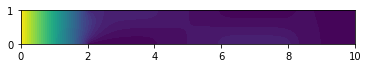

In [262]:
Diss,S,I,u_1,u_2,u_4,flux,mesh,v1,v2,phi = initialize_and_run(Voltage=10)

In [ ]:
plot(exp(u_1))

In [ ]:
plot(exp(u_2))

In [ ]:
plot(v2)

In [ ]:
plot(phi)